# Create Tail Risk protection indexes based on VEQTOR
### UKX, DAX, SHCOMP, NKY
The strategy allocates money to a combination of the selected equity index, VIX short term futures index (SPVXSTR) and cash based on 2 volatility signals:

1) Realized volatility = 22-days (monthly) standard deviation of the equity index.

2) Implied volatility trend = comparison of MA(5) and MA(20) for the VIX spot index:
- Upward trend if MA(5) > MA(20) over last 10 trading days.
- Downward trend if MA(5) < MA(20) over last 10 trading days.
- No trend if either of the other two not true.



### Allocation Matrix: 
Based on the paper () but I increased the allocation to SP when the signals imply the lower level of tail risk and increased the allocation to VIX futures when the implied tail risk was highest. I also eliminated the stop loss feature

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import math
sns.set()

from functions_thesis import *

In [2]:
# Import data
strategies = pd.read_excel("Data_tesi.xlsx", sheet_name="Monthly against tail risk", index_col="Dates")

strategies_daily = pd.read_excel("Data_tesi.xlsx", sheet_name="Daily against tail risk", index_col="Dates")

sp = pd.read_excel("Data_tesi.xlsx", sheet_name="SPY ETF monthly", index_col="Dates")

vxth = pd.read_excel("Data_tesi.xlsx", sheet_name="Daily against tail risk", index_col="Dates")
vxth = vxth["VXTH"]

#strat = strategies[["SPXT", "PPUT", "CLL", "CLLZ", "VXTH", "SPVQDTR", "LOVOL"]]
#strat = strat.dropna()
#strat_ret = np.log(1+strat.pct_change()).dropna()

strat_daily = strategies_daily[["SPXT", "PPUT", "CLL", "CLLZ", "VXTH", "SPVQDTR", "LOVOL"]]
strat_daily = strat_daily.dropna()
strat_daily_ret = np.log(1+strat_daily.pct_change()).dropna()

In [3]:
# Import world equity indexes data
ind = pd.read_excel("Data_tesi.xlsx", sheet_name="Daily All ", index_col="Dates")
equity = ind[["SPXT", "UKX", "DAX", "SHCOMP", "NKY"]]
equity_ret = np.log(1+equity.pct_change())

In [4]:
pd.options.mode.chained_assignment = None

def data_for_strategy(dataframe, ticker, vol_index, futures_index):
    """
    Inputs = dataframe with prices of equity index and equity index ticker
    """
    #Create the dataframe with the data needed
    spindex = pd.DataFrame(dataframe[ticker])                         # equity index
    x = spindex.merge(strategies_daily[vol_index], on="Dates")        # add VIX or alternatives
    x = x.merge(strategies_daily[futures_index], on="Dates").dropna() # add VIX futures or alternatives
    x.rename(columns={futures_index: "VIX_FUT"}, inplace=True)

    # Realized Volatility
    x["Ret_VIX_FUT"] = np.log(1+x["VIX_FUT"].pct_change())
    x["Ret_{}".format(ticker)] = np.log(1+x[ticker].pct_change())
    x["Realized_vol"] = np.sqrt((252*(x["Ret_{}".format(ticker)]**2).rolling(22).sum())/22)

    # Create Implied volatility signal
    # Moving averages for implied volatility trend
    x["MA5"] = x[vol_index].rolling(5).mean()
    x["MA20"] = x[vol_index].rolling(20).mean()
    x.dropna(inplace=True)
    x["MA_diff"] = x["MA5"] - x["MA20"]
    # np.where(condition, if condition true, if condition false)
    x["sig"] = np.where(x["MA_diff"]>0, 1, -1)  
    x["sum"] = x["sig"].rolling(10).sum()
    EVFC = x[9:]
    imp_trend = []
    for i in range(len(EVFC)):
        if EVFC["sum"].iloc[i] == 10:
            imp_trend.append(1)          # UPWARD TREND (all last ten days with MA5 > MA20)
        elif EVFC["sum"].iloc[i] == -10:
            imp_trend.append(-1)         # DOWNWARD TREND (all last ten days with MA5 < MA20)
        else:
            imp_trend.append(0)          # NO clear TREND

    EVFC["Implied_trend"] = imp_trend
    return EVFC

In [5]:
def create_index(dataframe, ticker, vol_index, futures_index):
    """
    Inputs = dataframe with PRICES of equity index and equity index ticker
    """
    df = data_for_strategy(dataframe=dataframe, ticker=ticker, vol_index=vol_index, futures_index=futures_index)
    sp = df["Ret_{}".format(ticker)].values
    fut = df["Ret_VIX_FUT"].values
    index = []
    wSP = []
    wFUT = []
    wSP.append(0)
    wFUT.append(0)
    index.append(0) # first zero to have same lenght as df
    for i in range(len(df)-1):  #not for the last because we don't have data for next day
        if (df["Realized_vol"].iloc[i] < 0.1) == True:
            if (df["Implied_trend"].iloc[i] == -1) == True:  # DOWNWARD
                index.append(sp[i+1]*1 + fut[i+1]*0)   #97.5
                wSP.append(1)
                wFUT.append(0)
            elif (df["Implied_trend"].iloc[i] == 1) == True: # UPWARD
                index.append(sp[i+1]*0.95 + fut[i+1]*(1-0.95))   #90
                wSP.append(0.95)
                wFUT.append(0.05)
            else: # NO TREND
                index.append(sp[i+1]*1 + fut[i+1]*0)  #97.5
                wSP.append(1)
                wFUT.append(0)
        elif ((df["Realized_vol"].iloc[i] >= 0.1) == True) and ((df["Realized_vol"].iloc[i] < 0.2) == True):
            if (df["Implied_trend"].iloc[i] == -1) == True:
                index.append(sp[i+1]*1 + fut[i+1]*0)    #97.5
                wSP.append(1)
                wFUT.append(0)
            elif (df["Implied_trend"].iloc[i] == 1) == True:
                index.append(sp[i+1]*0.85 + fut[i+1]*(1-0.85))
                wSP.append(0.85)
                wFUT.append(0.15)
            else:
                index.append(sp[i+1]*0.95 + fut[i+1]*(1-0.95))   #90
                wSP.append(0.95)
                wFUT.append(0.05)
        elif ((df["Realized_vol"].iloc[i] >= 0.2) == True) and ((df["Realized_vol"].iloc[i] < 0.35) == True):
            if (df["Implied_trend"].iloc[i] == -1) == True:
                index.append(sp[i+1]*0.95 + fut[i+1]*(1-0.95))   #90
                wSP.append(0.95)
                wFUT.append(0.05)
            elif (df["Implied_trend"].iloc[i] == 1) == True:
                index.append(sp[i+1]*0.75 + fut[i+1]*(1-0.75))
                wSP.append(0.75)
                wFUT.append(0.25)
            else:
                index.append(sp[i+1]*0.85 + fut[i+1]*(1-0.85)) 
                wSP.append(0.85)
                wFUT.append(0.15)
        elif ((df["Realized_vol"].iloc[i] >= 0.35) == True) and ((df["Realized_vol"].iloc[i] < 0.45) == True):
            if (df["Implied_trend"].iloc[i] == -1) == True:
                index.append(sp[i+1]*0.85 + fut[i+1]*(1-0.85))
                wSP.append(0.85)
                wFUT.append(0.15)
            elif (df["Implied_trend"].iloc[i] == 1) == True:
                index.append(sp[i+1]*0.5 + fut[i+1]*(1-0.5))   #60
                wSP.append(0.5)
                wFUT.append(0.5)
            else:
                index.append(sp[i+1]*0.75 + fut[i+1]*(1-0.75))
                wSP.append(0.75)
                wFUT.append(0.25) 
        else:
            if (df["Implied_trend"].iloc[i] == -1) == True:
                index.append(sp[i+1]*0.75 + fut[i+1]*(1-0.75)) 
                wSP.append(0.75)
                wFUT.append(0.25)
            elif (df["Implied_trend"].iloc[i] == 1) == True:
                index.append(sp[i+1]*0.5 + fut[i+1]*(1-0.5))   #60
                wSP.append(0.5)
                wFUT.append(0.5)
            else:
                index.append(sp[i+1]*0.5 + fut[i+1]*(1-0.5))   #60
                wSP.append(0.5)
                wFUT.append(0.5)

    df["Ret_INDEX"] = index
    return df, wSP, wFUT

EF1 = create_index(equity, "SPXT", "VIX", "SPVXSTR")[0]
EF1.to_excel("MyVEQ.xlsx")

In [6]:
# Get the allocation weights
wsp, wfut = create_index(equity, "SPXT", "VIX", "SPVXSTR")[1:3]
wsp = np.array(wsp)
wfut = np.array(wfut)

weights_data = pd.DataFrame({"SP_weights": wsp, "VIXFut_weights": wfut, "Tot": (wsp+wfut)}, index=EF1.index)

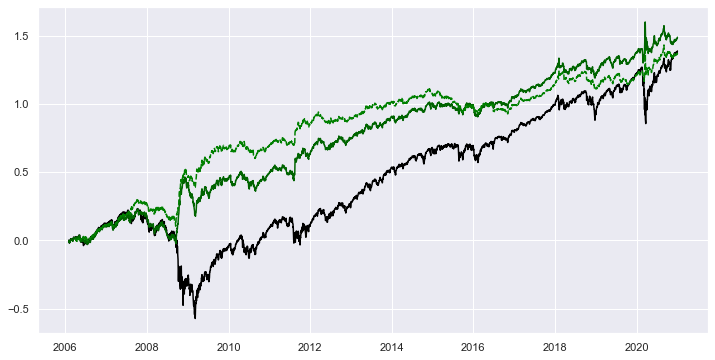

In [7]:
# Daily data
plt.figure(figsize=(12, 6))
plt.plot(EF1["Ret_SPXT"].cumsum(), "black")
plt.plot(EF1["Ret_INDEX"].cumsum(), "darkgreen");
plt.plot(strat_daily_ret["SPVQDTR"].cumsum(), "green", linestyle="--");

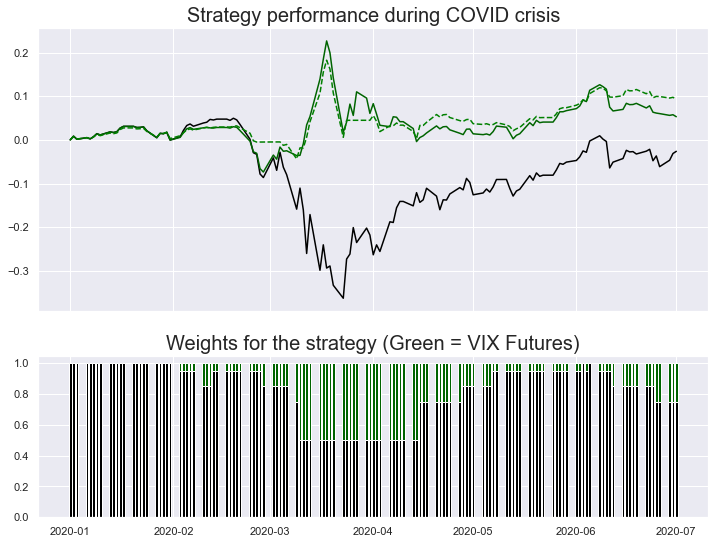

In [8]:
# Strategy in 2020 crisis
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [7, 4]}, figsize=(12, 9), sharex=True)
ax[0].plot(EF1["Ret_SPXT"].loc["2020-01-01":"2020-07-01"].cumsum(), "black")
ax[0].plot(EF1["Ret_INDEX"].loc["2020-01-01":"2020-07-01"].cumsum(), "darkgreen")
ax[0].plot(strat_daily_ret["SPVQDTR"].loc["2020-01-01":"2020-07-01"].cumsum(), "green", linestyle="--")
ax[0].set_title("Strategy performance during COVID crisis", fontsize=20)
ax[1].bar(x=weights_data.loc["2020-01-01":"2020-07-01"].index, height=weights_data["Tot"].loc["2020-01-01":"2020-07-01"], color="darkgreen")
ax[1].bar(x=weights_data.loc["2020-01-01":"2020-07-01"].index, height=weights_data["SP_weights"].loc["2020-01-01":"2020-07-01"], color="black")
ax[1].set_title("Weights for the strategy (Green = VIX Futures)", fontsize=20);

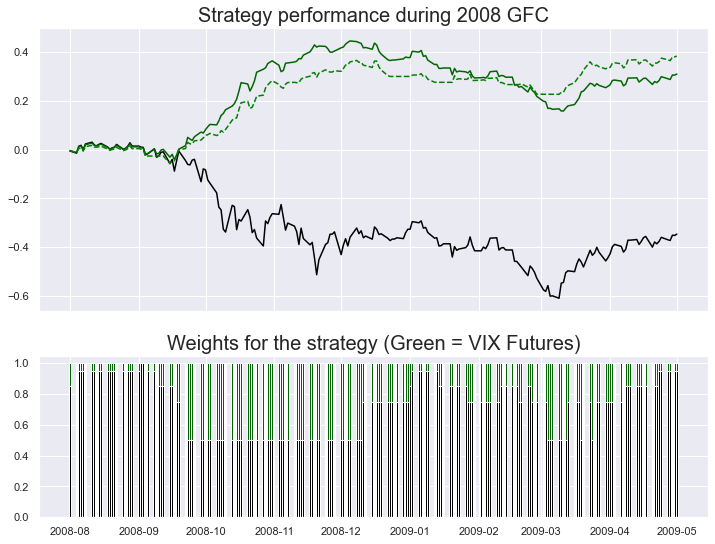

In [9]:
# Strategy in 2008 GFC
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [7, 4]}, figsize=(12, 9), sharex=True)
ax[0].plot(EF1["Ret_SPXT"].loc["2008-08-01":"2009-05-01"].cumsum(), "black")
ax[0].plot(EF1["Ret_INDEX"].loc["2008-08-01":"2009-05-01"].cumsum(), "darkgreen")
ax[0].plot(strat_daily_ret["SPVQDTR"].loc["2008-08-01":"2009-05-01"].cumsum(), "green", linestyle="--")
ax[0].set_title("Strategy performance during 2008 GFC", fontsize=20)
ax[1].bar(x=weights_data.loc["2008-08-01":"2009-05-01"].index, height=weights_data["Tot"].loc["2008-08-01":"2009-05-01"], color="darkgreen")
ax[1].bar(x=weights_data.loc["2008-08-01":"2009-05-01"].index, height=weights_data["SP_weights"].loc["2008-08-01":"2009-05-01"], color="black")
ax[1].set_title("Weights for the strategy (Green = VIX Futures)", fontsize=20);

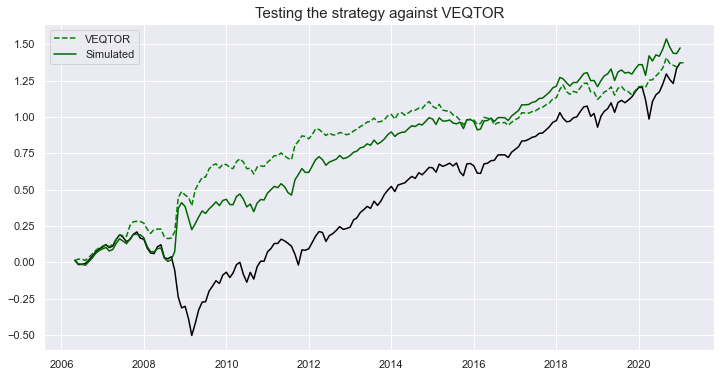

In [10]:
# Resample and plot to compare with actual VEQTOR
mont1 = EF1[["Ret_SPXT", "Ret_INDEX"]].resample("M").sum()
veq = strat_daily_ret["SPVQDTR"].resample("M").sum()

plt.figure(figsize=(12, 6))
plt.plot(mont1["Ret_SPXT"].iloc[2:].cumsum(), "black")
#plt.plot(strat_ret["SPVQDTR"].cumsum(), "green",linestyle="--", label="VEQTOR")
plt.plot(veq.cumsum(), "green",linestyle="--", label="VEQTOR")
plt.plot(mont1["Ret_INDEX"].iloc[2:].cumsum(), "darkgreen", label="Simulated")
plt.title("Testing the strategy against VEQTOR", fontsize=15)
plt.legend();

In [11]:
# Add cash stop loss
#EF["5dayret"] = EF["Ret_INDEX"].rolling(5, min_periods=1).sum()
#index_cash = []
#index_cash.append(EF["Ret_INDEX"].iloc[0])
#for i in range(1, len(EF)):
    #if (EF["5dayret"].iloc[i-1] < -0.02) == True:
        #index_cash.append(0.0)
    #else:
        #index_cash.append(EF["Ret_INDEX"].iloc[i])

#EF["Ret_INDEX_cash"] = index_cash

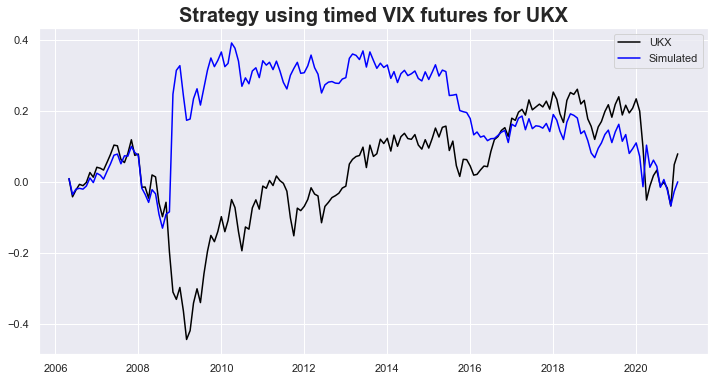

In [12]:
# EQUITY INDEX DIFFERENT from SP500
EF2 = create_index(equity, "UKX", "VIX", "SPVXSTR")[0]
# Resample and plot
mont2 = EF2[["Ret_UKX", "Ret_INDEX"]].resample("M").sum()

plt.figure(figsize=(12, 6))
plt.plot(mont2["Ret_UKX"].iloc[2:].cumsum(), "black", label="UKX")
plt.plot(mont2["Ret_INDEX"].iloc[2:].cumsum(), "blue",label="Simulated")
plt.title("Strategy using timed VIX futures for UKX", fontsize=20, fontweight="bold")
plt.legend();

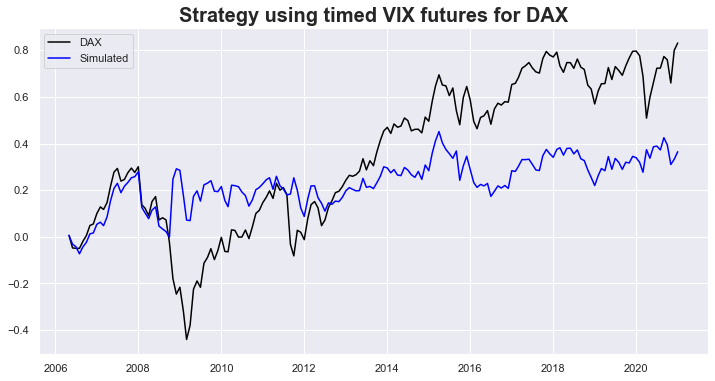

In [13]:
EF3 = create_index(equity, "DAX", "VIX", "SPVXSTR")[0]
# Resample and plot
mont3 = EF3[["Ret_DAX", "Ret_INDEX"]].resample("M").sum()

plt.figure(figsize=(12, 6))
plt.plot(mont3["Ret_DAX"].iloc[2:].cumsum(), "black", label="DAX")
plt.plot(mont3["Ret_INDEX"].iloc[2:].cumsum(), "blue",label="Simulated")
plt.title("Strategy using timed VIX futures for DAX", fontsize=20, fontweight="bold")
plt.legend();

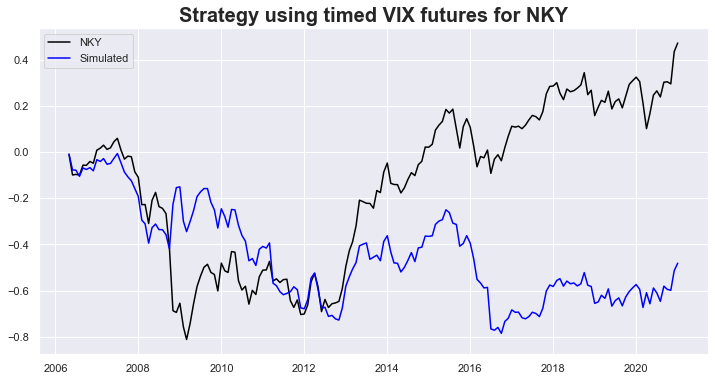

In [14]:
EF4 = create_index(equity, "NKY", "VIX", "SPVXSTR")[0]
# Resample and plot
mont4 = EF4[["Ret_NKY", "Ret_INDEX"]].resample("M").sum()

plt.figure(figsize=(12, 6))
plt.plot(mont4["Ret_NKY"].iloc[2:].cumsum(), "black", label="NKY")
plt.plot(mont4["Ret_INDEX"].iloc[2:].cumsum(), "blue", label="Simulated")
plt.title("Strategy using timed VIX futures for NKY", fontsize=20, fontweight="bold")
plt.legend();

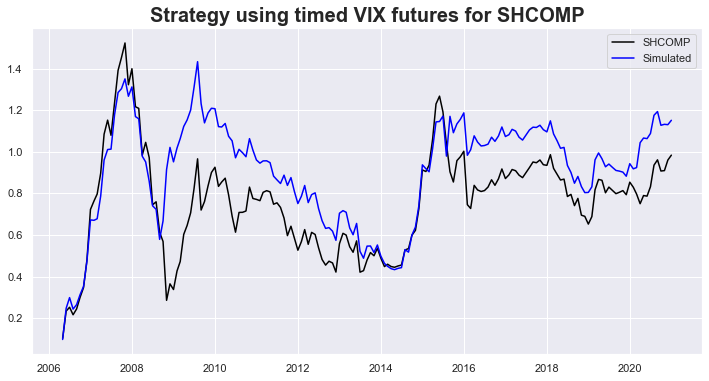

In [15]:
EF5 = create_index(equity, "SHCOMP", "VIX", "SPVXSTR")[0]
# Resample and plot
mont5 = EF5[["Ret_SHCOMP", "Ret_INDEX"]].resample("M").sum()

plt.figure(figsize=(12, 6))
plt.plot(mont5["Ret_SHCOMP"].iloc[2:].cumsum(), "black", label="SHCOMP")
plt.plot(mont5["Ret_INDEX"].iloc[2:].cumsum(), "blue", label="Simulated")
plt.title("Strategy using timed VIX futures for SHCOMP", fontsize=20, fontweight="bold")
plt.legend();

In [16]:
traditional_metrics(mont2, EF5, no_price=True)   # EF5 not used

/Users/AlessioGiust/Desktop/TESI/Codici Tesi/functions_thesis.py:26: RuntimeWarning: invalid value encountered in double_scalars
  IR.append((avg_ret_data[tick] - avg_ret_data[index_tick])/(qq["diff_sp_{}".format(tick)].std()))


,CAGR,Monthly Return,Monthly Volatility,Sharpe,Sortino,IR,VaR,CVaR,Max Drawdown
Ret_UKX,0.007691,0.000641,0.040670,0.015758,0.020898,NaN,0.069696,0.100089,-0.386393
Ret_INDEX,0.001732,0.000144,0.040241,0.003588,0.006893,-0.01082,0.053600,0.072069,-0.165629


In [17]:
traditional_metrics(mont3, EF5, no_price=True)   # EF5 not used

/Users/AlessioGiust/Desktop/TESI/Codici Tesi/functions_thesis.py:26: RuntimeWarning: invalid value encountered in double_scalars
  IR.append((avg_ret_data[tick] - avg_ret_data[index_tick])/(qq["diff_sp_{}".format(tick)].std()))


,CAGR,Monthly Return,Monthly Volatility,Sharpe,Sortino,IR,VaR,CVaR,Max Drawdown
Ret_DAX,0.059185,0.004932,0.054809,0.089987,0.112650,NaN,0.096666,0.137051,-0.513330
Ret_INDEX,0.026437,0.002203,0.044246,0.049792,0.079045,-0.05314,0.055987,0.094555,-0.232929


In [18]:
traditional_metrics(mont4, EF5, no_price=True)   #EF5 not used

/Users/AlessioGiust/Desktop/TESI/Codici Tesi/functions_thesis.py:26: RuntimeWarning: invalid value encountered in double_scalars
  IR.append((avg_ret_data[tick] - avg_ret_data[index_tick])/(qq["diff_sp_{}".format(tick)].std()))


,CAGR,Monthly Return,Monthly Volatility,Sharpe,Sortino,IR,VaR,CVaR,Max Drawdown
Ret_NKY,0.033503,0.002792,0.056976,0.049002,0.060064,NaN,0.096182,0.133143,-0.546555
Ret_INDEX,-0.031474,-0.002623,0.048681,-0.053877,-0.072805,-0.115039,0.079407,0.115839,-0.373128


In [19]:
traditional_metrics(mont5, EF5, no_price=True)   #EF5 not used

/Users/AlessioGiust/Desktop/TESI/Codici Tesi/functions_thesis.py:26: RuntimeWarning: invalid value encountered in double_scalars
  IR.append((avg_ret_data[tick] - avg_ret_data[index_tick])/(qq["diff_sp_{}".format(tick)].std()))


,CAGR,Monthly Return,Monthly Volatility,Sharpe,Sortino,IR,VaR,CVaR,Max Drawdown
Ret_SHCOMP,0.068077,0.005673,0.080909,0.070116,0.087184,NaN,0.146931,0.214025,-0.759048
Ret_INDEX,0.078378,0.006531,0.071354,0.091537,0.139884,0.014846,0.092450,0.156589,-0.579443


In [20]:
specific_metrics(mont2, 0.0, -0.05, -0.1)

,Avg Performance Drag,Bull Drag,Certainty,Avg Tail return
Ret_UKX,0.000000,0.000000,0.0,-0.125815
Ret_INDEX,-0.000497,-0.012628,30.0,-0.016669


In [21]:
specific_metrics(mont3, 0.0, -0.05, -0.1)

,Avg Performance Drag,Bull Drag,Certainty,Avg Tail return
Ret_DAX,0.000000,0.0000,0.0,-0.148133
Ret_INDEX,-0.002729,-0.0179,28.0,-0.081180


In [22]:
specific_metrics(mont4, 0.0, -0.05, -0.1)

,Avg Performance Drag,Bull Drag,Certainty,Avg Tail return
Ret_NKY,0.000000,0.000000,0.000000,-0.133143
Ret_INDEX,-0.005415,-0.017762,10.344828,-0.092142


In [23]:
specific_metrics(mont5, 0.0, -0.05, -0.1)

,Avg Performance Drag,Bull Drag,Certainty,Avg Tail return
Ret_SHCOMP,0.000000,0.000000,0.000000,-0.192355
Ret_INDEX,0.000858,-0.016064,14.705882,-0.137185


## Equal weighted portfolio with tail-risk insured indexes

In [24]:
portfolio = mont1.merge(mont2, on="Dates")
portfolio.rename(columns={"Ret_INDEX_x": "INDEX_SP", "Ret_INDEX_y": "INDEX_UKX"}, inplace=True)
portfolio = portfolio.merge(mont3, on="Dates")
portfolio.rename(columns={"Ret_INDEX": "INDEX_DAX"}, inplace=True)
portfolio = portfolio.merge(mont4, on="Dates")
portfolio.rename(columns={"Ret_INDEX": "INDEX_NKY"}, inplace=True)
portfolio = portfolio.merge(mont5, on="Dates")
portfolio.rename(columns={"Ret_INDEX": "INDEX_SHCOMP"}, inplace=True)

In [25]:
portfolio["Basic"] = portfolio["Ret_SPXT"]*1/5 + portfolio["Ret_UKX"]*1/5 + portfolio["Ret_DAX"]*1/5 + portfolio["Ret_SHCOMP"]*1/5 + portfolio["Ret_NKY"]*1/5
portfolio["Insured"] = portfolio["INDEX_SP"]*1/5 + portfolio["INDEX_UKX"]*1/5 + portfolio["INDEX_DAX"]*1/5 + portfolio["INDEX_SHCOMP"]*1/5 + portfolio["INDEX_NKY"]*1/5

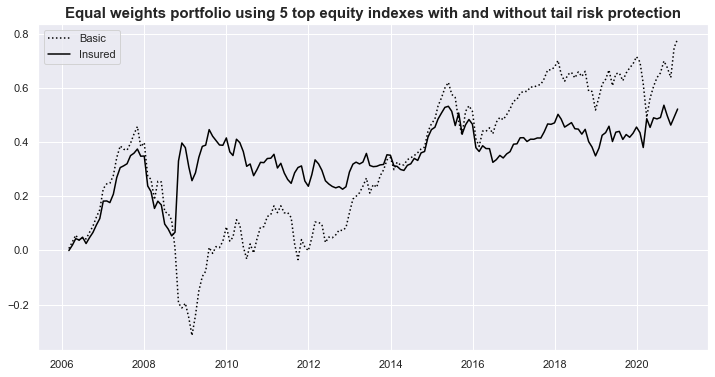

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(portfolio["Basic"].cumsum(), "black", linestyle=":", label="Basic")
plt.plot(portfolio["Insured"].cumsum(), "black", label="Insured")
plt.title("Equal weights portfolio using 5 top equity indexes with and without tail risk protection", fontsize=15, fontweight="bold")
plt.legend();

# Traditional Portfolio Optimization Methods based on diversification 
This methods are based on a target monthly S&P return and they're rebalanced monthly. Assets included are top world indexes (), commodities index (BCOM), US bonds index (LBUSTRUU) and Gold (XAU).
- Markowitz mean-variance optimization
- CVaR minimization

In [27]:
#import
opt_port = pd.read_csv("/Users/AlessioGiust/Desktop/TESI/optR.csv", index_col="Unnamed: 0")

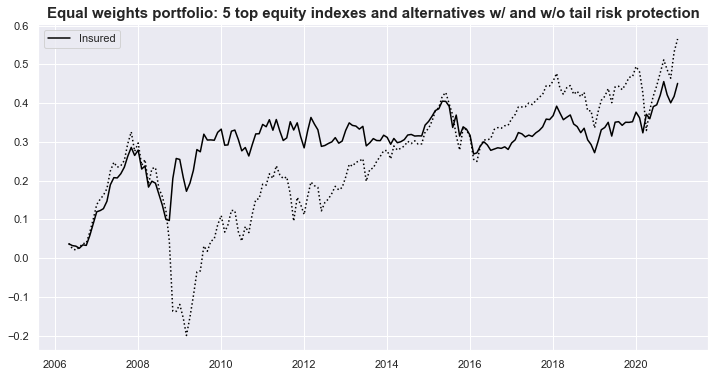

In [28]:
# EQUAL WEIGHTS
eq_weig = [1/8]*8
port = opt_port[['LBUSTRUU', 'SPY', 'XAU', 'BCOM', 'DAX', 'SHCOMP', 'UKX', 'NKY']]
port.index = pd.to_datetime(port.index)
port = port.resample("M").sum()
pofo = port[3:]
pofo = pofo.merge(portfolio, left_index=True, right_index=True)
pofo.drop(columns=["Ret_SPXT", "Ret_UKX", "Ret_DAX", "Ret_NKY", "Ret_SHCOMP"], inplace=True)
pofo["Equal_Basic"] = (pofo[['LBUSTRUU', 'SPY', 'XAU', 'BCOM', 'DAX', 'SHCOMP', 'UKX', 'NKY']]*eq_weig).sum(axis=1)
pofo["Equal_Insured"] = (pofo[['LBUSTRUU', 'INDEX_SP', 'XAU', 'BCOM', 'INDEX_DAX', 'INDEX_SHCOMP', 'INDEX_UKX', 'INDEX_NKY']]*eq_weig).sum(axis=1)

#plot
plt.figure(figsize=(12, 6))
plt.plot(pofo["Equal_Basic"].cumsum(), "black", linestyle=":")
plt.plot(pofo["Equal_Insured"].cumsum(), "black", label="Insured")
plt.title("Equal weights portfolio: 5 top equity indexes and alternatives w/ and w/o tail risk protection", fontsize=15, fontweight="bold")
plt.legend();

In [29]:
# MAX RETURNS and MIN EXPECTED TAIL LOSS portfolios (no rebalancing)
no_reb = pd.read_csv("/Users/AlessioGiust/Desktop/TESI/weights_norebR.csv", index_col="Unnamed: 0")
w_max_ret = no_reb["w1"].values
w_min_etl = no_reb["w2"].values

pofo["Max_ret"] = (pofo[['LBUSTRUU', 'SPY', 'XAU', 'BCOM', 'DAX', 'SHCOMP', 'UKX', 'NKY']]*w_max_ret).sum(axis=1)
pofo["Max_ret_insured"] =(pofo[['LBUSTRUU', 'INDEX_SP', 'XAU', 'BCOM', 'INDEX_DAX', 'INDEX_SHCOMP', 'INDEX_UKX', 'INDEX_NKY']]*w_max_ret).sum(axis=1)
pofo["Min_ETL"] = (pofo[['LBUSTRUU', 'SPY', 'XAU', 'BCOM', 'DAX', 'SHCOMP', 'UKX', 'NKY']]*w_min_etl).sum(axis=1)
pofo["Min_ETL_insured"] = (pofo[['LBUSTRUU', 'INDEX_SP', 'XAU', 'BCOM', 'INDEX_DAX', 'INDEX_SHCOMP', 'INDEX_UKX', 'INDEX_NKY']]*w_min_etl).sum(axis=1)

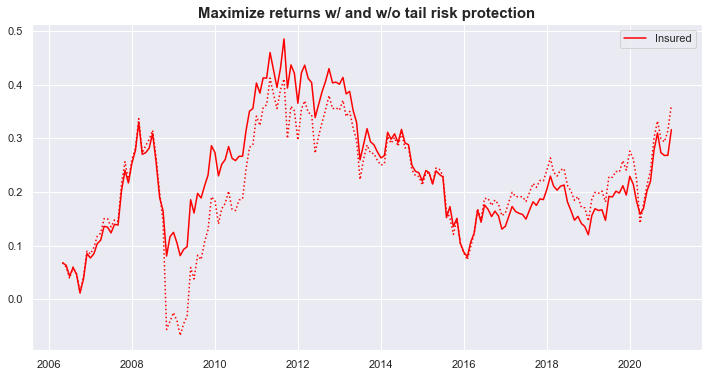

In [30]:
# MAX RETURNS
plt.figure(figsize=(12, 6))
plt.plot(pofo["Max_ret"].cumsum(), "red", linestyle=":")
plt.plot(pofo["Max_ret_insured"].cumsum(), "red", label="Insured")
plt.title("Maximize returns w/ and w/o tail risk protection", fontsize=15, fontweight="bold")
plt.legend();

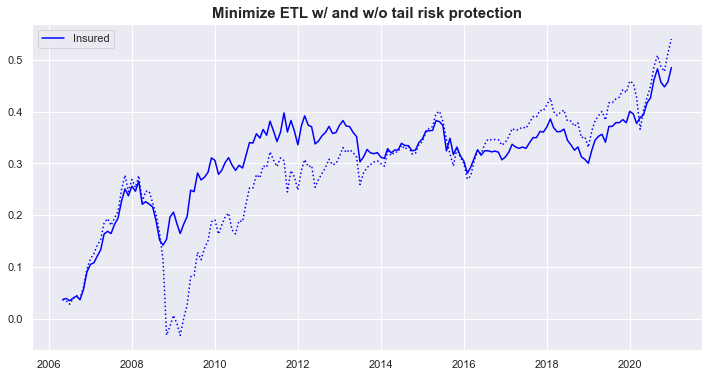

In [31]:
# MIN ETL
plt.figure(figsize=(12, 6))
plt.plot(pofo["Min_ETL"].cumsum(), "blue", linestyle=":")
plt.plot(pofo["Min_ETL_insured"].cumsum(), "blue", label="Insured")
plt.title("Minimize ETL w/ and w/o tail risk protection", fontsize=15, fontweight="bold")
plt.legend();

In [32]:
# REBALANCING annually w/ and w/o tail protection

############# MAX RETURNS #############
weig = pd.read_csv("/Users/AlessioGiust/Desktop/TESI/weightsR.csv", index_col="Unnamed: 0")
weig.rename(columns={"w1": "wr0"}, inplace=True)

# rebal1 for not insured, rebal2 for insured
rebal1 = pofo[['LBUSTRUU', 'SPY', 'XAU', 'BCOM', 'DAX', 'SHCOMP', 'UKX', 'NKY']]
rebal2 = pofo[['LBUSTRUU', 'INDEX_SP', 'XAU', 'BCOM', 'INDEX_DAX', 'INDEX_SHCOMP', 'INDEX_UKX', 'INDEX_NKY']]
rebal1["Portfolio"] = np.zeros(len(rebal1))
rebal2["Portfolio"] = np.zeros(len(rebal2))

############# MIN ETL #############
etl_reb = pd.read_csv("/Users/AlessioGiust/Desktop/TESI/weights_etlrebR.csv", index_col="Unnamed: 0")
etl_reb.rename(columns={"w2": "wr0"}, inplace=True)

rebal1["PortfolioETL"] = np.zeros(len(rebal1))
rebal2["PortfolioETL"] = np.zeros(len(rebal2))

In [33]:
for i in range(14):
    if i < 13:
        ############# MAX RET
        rebal1["Portfolio"].loc[12*i:12*(i+1)] = (rebal1[['LBUSTRUU', 'SPY', 'XAU', 'BCOM', 
        'DAX', 'SHCOMP', 'UKX', 'NKY']]*weig[f"wr{i}"].values).sum(axis=1)
        # insured
        rebal2["Portfolio"].loc[12*i:12*(i+1)] = (rebal2[['LBUSTRUU', 'INDEX_SP', 'XAU', 'BCOM', 'INDEX_DAX', 
        'INDEX_SHCOMP', 'INDEX_UKX', 'INDEX_NKY']]*weig[f"wr{i}"].values).sum(axis=1)
        ############# MIN ETL
        rebal1["PortfolioETL"].loc[12*i:(12*(i+1))] = (rebal1[['LBUSTRUU', 'SPY', 'XAU', 'BCOM', 
        'DAX', 'SHCOMP', 'UKX', 'NKY']]*etl_reb[f"wr{i}"].values).sum(axis=1)
        # insured 
        rebal2["PortfolioETL"].loc[12*i:(12*(i+1))] = (rebal2[['LBUSTRUU', 'INDEX_SP', 'XAU', 'BCOM', 'INDEX_DAX',
        'INDEX_SHCOMP', 'INDEX_UKX', 'INDEX_NKY']]*etl_reb[f"wr{i}"].values).sum(axis=1)
    else:
        ############# MAX RET
        rebal1["Portfolio"].loc[12*i:] = (rebal1[['LBUSTRUU', 'SPY', 'XAU', 'BCOM', 'DAX', 
        'SHCOMP', 'UKX', 'NKY']]*weig[f"wr{i}"].values).sum(axis=1)
        # insured
        rebal2["Portfolio"].loc[12*i:] = (rebal2[['LBUSTRUU', 'INDEX_SP', 'XAU', 'BCOM', 'INDEX_DAX', 
        'INDEX_SHCOMP', 'INDEX_UKX', 'INDEX_NKY']]*weig[f"wr{i}"].values).sum(axis=1)
        ############# MIN ETL
        rebal1["PortfolioETL"].loc[12*i:] = (rebal1[['LBUSTRUU', 'SPY', 'XAU', 'BCOM', 'DAX', 
        'SHCOMP', 'UKX', 'NKY']]*etl_reb[f"wr{i}"].values).sum(axis=1)
        # insured
        rebal2["PortfolioETL"].loc[12*i:] = (rebal2[['LBUSTRUU', 'INDEX_SP', 'XAU', 'BCOM', 'INDEX_DAX', 
        'INDEX_SHCOMP', 'INDEX_UKX', 'INDEX_NKY']]*etl_reb[f"wr{i}"].values).sum(axis=1)

/Users/AlessioGiust/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


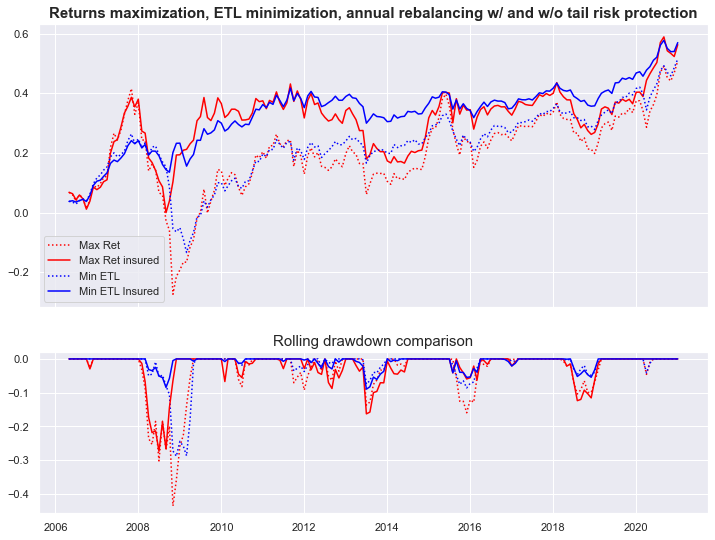

In [34]:
# Plot the results
drd1 = drawdown(rebal1[["Portfolio", "PortfolioETL"]])
drd2 = drawdown(rebal2[["Portfolio", "PortfolioETL"]])

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [7, 4]}, figsize=(12, 9), sharex=True)
ax[0].plot(rebal1["Portfolio"].cumsum(),  "red", linestyle=":", label = "Max Ret")
ax[0].plot(rebal2["Portfolio"].cumsum(), "red", label="Max Ret insured")
ax[0].plot(rebal1["PortfolioETL"].cumsum(), "blue", linestyle=":", label="Min ETL")
ax[0].plot(rebal2["PortfolioETL"].cumsum(), "blue", label="Min ETL Insured")
ax[0].set_title("Returns maximization, ETL minimization, annual rebalancing w/ and w/o tail risk protection", fontsize=15, fontweight="bold")
ax[0].legend()
ax[1].plot(drd1["Portfolio"], "red", linestyle=":")
ax[1].plot(drd1["PortfolioETL"], "blue", linestyle=":")
ax[1].plot(drd2["Portfolio"], "red")
ax[1].plot(drd2["PortfolioETL"], "blue")
ax[1].set_title("Rolling drawdown comparison", fontsize=15);

# Analysis for EUROSTOXX using:
## - Specific volatility index (VSTOXX)
## - Specific index tracking futures on VSTOXX (VST1MSL)

In [35]:
dataeuro = strategies_daily[["EUROSTOXX", "VSTOXX", "VST1MSL"]]
dataeuro = dataeuro.dropna()
dataeuro_ret = np.log(1+dataeuro.pct_change()).dropna()

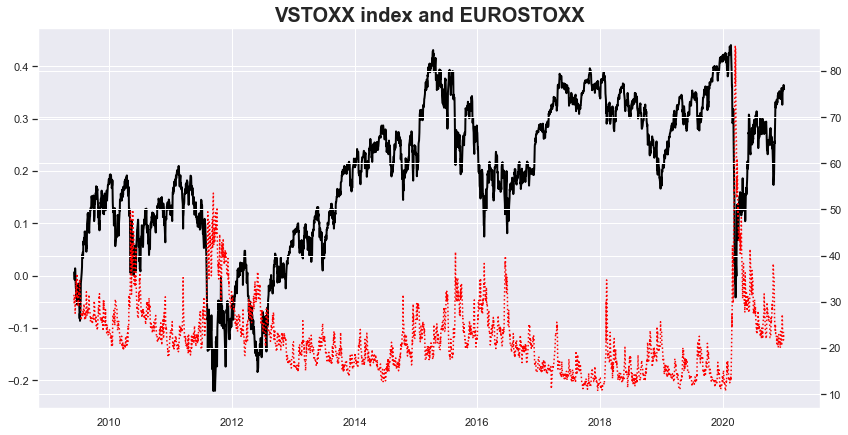

In [36]:
fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.plot(dataeuro_ret["EUROSTOXX"].cumsum(), "black", linewidth=2)
ax2 = ax1.twinx()
ax2.plot(dataeuro["VSTOXX"], "red", linestyle=":")
plt.title("VSTOXX index and EUROSTOXX", fontsize=20, fontweight="bold");

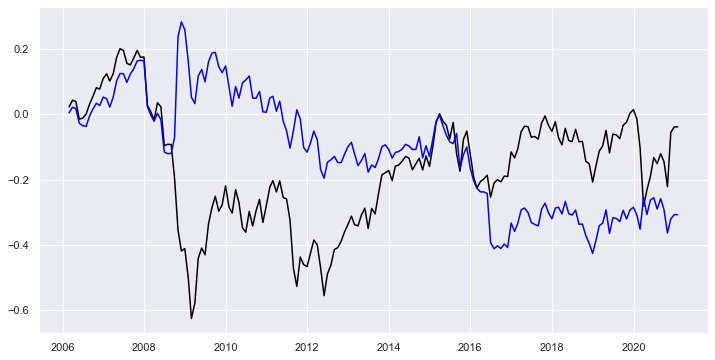

In [37]:
# Application to EUROSTOXX with BAD DATA but considering also the GFC
IND = create_index(strategies_daily, "EUROSTOXX", "VIX", "SPVXSTR")[0]
montIND = IND[["Ret_EUROSTOXX", "Ret_INDEX"]].resample("M").sum()

plt.figure(figsize=(12, 6))
plt.plot(montIND["Ret_EUROSTOXX"].cumsum(), "black")
plt.plot(montIND["Ret_INDEX"].cumsum(), "blue");

In [38]:
########## EUROSTOXX with BAD DATA
IND1, weu1, wfut1 = create_index(dataeuro, "EUROSTOXX", "VIX", "SPVXSTR")
weu1 = np.array(weu1)
wfut1 = np.array(wfut1)
weights_data1 = pd.DataFrame({"EUROSTOXX_weights": weu1, "VIXFut_weights": wfut1, "Tot": (weu1+wfut1)}, index=IND1.index)

########## EUROSTOXX with GOOD DATA
IND2, weu2, wfut2 = create_index(dataeuro, "EUROSTOXX", "VSTOXX", "VST1MSL")
weu2 = np.array(weu2)
wfut2 = np.array(wfut2)
weights_data2 = pd.DataFrame({"EUROSTOXX_weights": weu2, "VIXFut_weights": wfut2, "Tot": (weu2+wfut2)}, index=IND2.index)

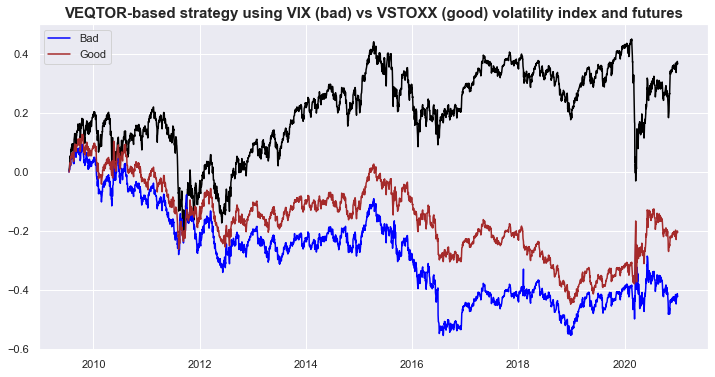

In [39]:
# Daily data
plt.figure(figsize=(12, 6))
plt.plot(IND1["Ret_EUROSTOXX"].cumsum(), "black")
plt.plot(IND1["Ret_INDEX"].cumsum(), "blue", label="Bad")
plt.plot(IND2["Ret_INDEX"].cumsum(), "brown", label="Good")
plt.title("VEQTOR-based strategy using VIX (bad) vs VSTOXX (good) volatility index and futures", fontsize=15, fontweight="bold")
plt.legend();

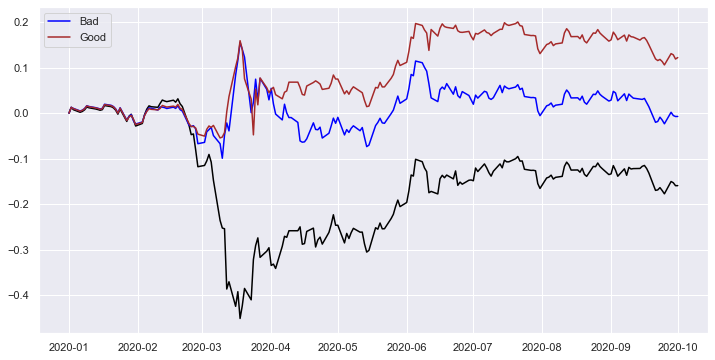

In [40]:
# Startegy during 2020 COVID
plt.figure(figsize=(12, 6))
plt.plot(IND1["Ret_EUROSTOXX"].loc["2020-01-01":"2020-10-01"].cumsum(), "black")
plt.plot(IND1["Ret_INDEX"].loc["2020-01-01":"2020-10-01"].cumsum(), "blue", label="Bad")
plt.plot(IND2["Ret_INDEX"].loc["2020-01-01":"2020-10-01"].cumsum(), "brown", label="Good")
plt.legend();

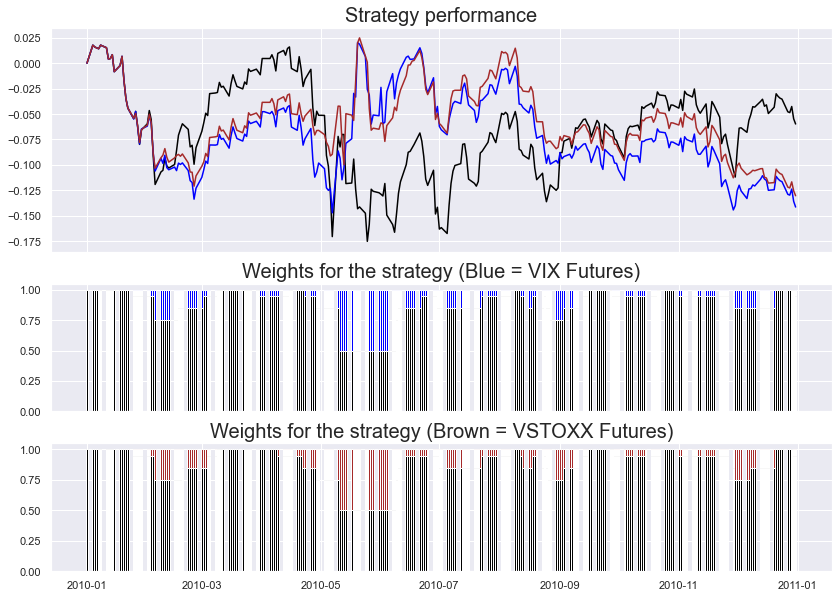

In [41]:
# Strategy in detail
st = "2010-01-01"
en = "2011-01-01"

fig, ax = plt.subplots(3, 1, gridspec_kw={'height_ratios': [7, 4, 4]}, figsize=(14, 10), sharex=True)
ax[0].plot(IND1["Ret_EUROSTOXX"].loc[st:en].cumsum(), "black")
ax[0].plot(IND1["Ret_INDEX"].loc[st:en].cumsum(), "blue")
ax[0].plot(IND2["Ret_INDEX"].loc[st:en].cumsum(), "brown")
ax[0].set_title("Strategy performance", fontsize=20)
ax[1].bar(x=weights_data1.loc[st:en].index, height=weights_data1["Tot"].loc[st:en], color="blue")
ax[1].bar(x=weights_data1.loc[st:en].index, height=weights_data1["EUROSTOXX_weights"].loc[st:en], color="black")
ax[1].set_title("Weights for the strategy (Blue = VIX Futures)", fontsize=20)
ax[2].bar(x=weights_data2.loc[st:en].index, height=weights_data2["Tot"].loc[st:en], color="brown")
ax[2].bar(x=weights_data2.loc[st:en].index, height=weights_data2["EUROSTOXX_weights"].loc[st:en], color="black")
ax[2].set_title("Weights for the strategy (Brown = VSTOXX Futures)", fontsize=20);